# Example on how to use zizou to detect anomalous signals

We will request data from station MAVZ at Mt. Ruapehu which recorded a
volcano-seismic signal on 7 March around 10 am UTC. We will train an autoencoder on data from the preceding three days and then check whether the autoencoder loss will increase during the time of the volcano-seismic signal. 

In [1]:
from obspy import UTCDateTime
from zizou import SSAM, RSAM, DSAR, SpectralFeatures, FDSNWaveforms, DataSource, AutoEncoder,EnergyExplainedByRSAM
from zizou.visualise import multi_feature_plot_mpl 
from tonik import Storage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
fw = FDSNWaveforms(url="GeoNet")
ds = DataSource(clients=[fw])
starttime_test = UTCDateTime("2024-03-07T00:00:00")
endtime_test = starttime_test + 86400
starttime_training = UTCDateTime("2024-03-04T00:00:00")
endtime_training = UTCDateTime("2024-03-06T23:59:59")
rawdata = next(ds.get_waveforms("NZ", "MAVZ", "10", "HHZ", starttime_training, endtime_test, cache=True))

## Compute Features

Next we will compute a few typical seismic features and store them using the [tonik](https://tsc-tools.github.io/tonik/) package:

In [3]:
r = RSAM(interval=600)
spec = SSAM(interval=60, resample_int=(None, '10min'))
sf = SpectralFeatures(interval=600)
re = EnergyExplainedByRSAM(interval=600)
dsar = DSAR(interval=600)
s = Storage('anomaly_detection_test', rootdir='/tmp',
            starttime=starttime_training.datetime,
            endtime=endtime_training.datetime)
st = s.get_substore('NZ', 'MAVZ', '10', 'HHZ')
for feature in [r, spec, sf, re, dsar]:
    xds = feature.compute(rawdata)
    st.save(xds, mode='w')

2024-10-15 23:44:34:zizou.rsam:2968820:96 INFO Computing RSAM for NZ.MAVZ.10.HHZ between 2024-03-04T00:00:00.003130 and 2024-03-07T23:59:59.993130.
2024-10-15 23:44:37:zizou.ssam:2968820:288 INFO Computing spectrograms for NZ.MAVZ.10.HHZ between 2024-03-04T00:00:00.003130 and 2024-03-07T23:59:59.993130.
2024-10-15 23:44:40:zizou.spectral_features:2968820:64 INFO Computing spectral features for NZ.MAVZ.10.HHZ between 2024-03-04T00:00:00.003130 and 2024-03-07T23:59:59.993130.
2024-10-15 23:44:48:zizou.rsam:2968820:208 INFO Computing Energy explained by RSAM for NZ.MAVZ.10.HHZ between 2024-03-04T00:00:00.003130 and 2024-03-07T23:59:59.993130.
2024-10-15 23:44:52:zizou.dsar:2968820:91 INFO Computing DSAR for NZ.MAVZ.10.HHZ between 2024-03-04T00:00:00.003130 and 2024-03-07T23:59:59.993130.


Once features have been computed we can request them using tonik's Storage class:

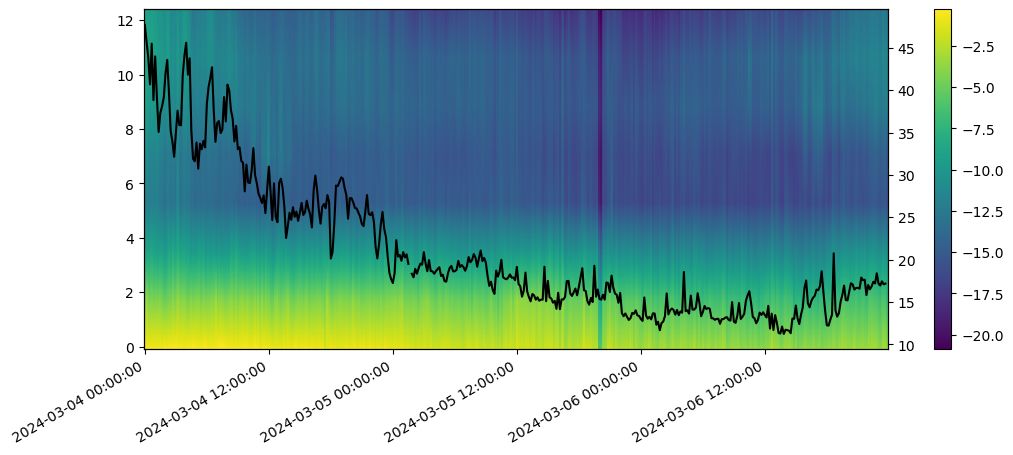

In [4]:
sono = st('sonogram')
rsam = st('rsam')
_ = multi_feature_plot_mpl(sono, rsam)

Now we can run the autoencoder for anomaly detection. Note, that it depends on the scikit-learn and pytorch packages. These are not intalled with the package so you will have to install them manually.

In [5]:
ac = AutoEncoder(epochs=100)
ac.fit(st, new=True)

2024-10-15 23:45:02:zizou.autoencoder:2968820:224 INFO Using cpu device
2024-10-15 23:45:02:zizou.autoencoder:2968820:232 INFO TiedAutoEncoder(
  (weights): ParameterList(
      (0): Parameter containing: [torch.float64 of size 2000x14]
      (1): Parameter containing: [torch.float64 of size 500x2000]
      (2): Parameter containing: [torch.float64 of size 200x500]
      (3): Parameter containing: [torch.float64 of size 6x200]
  )
  (enc_biases): ParameterList(
      (0): Parameter containing: [torch.float64 of size 2000]
      (1): Parameter containing: [torch.float64 of size 500]
      (2): Parameter containing: [torch.float64 of size 200]
      (3): Parameter containing: [torch.float64 of size 6]
  )
  (dec_biases): ParameterList(
      (0): Parameter containing: [torch.float64 of size 200]
      (1): Parameter containing: [torch.float64 of size 500]
      (2): Parameter containing: [torch.float64 of size 2000]
      (3): Parameter containing: [torch.float64 of size 14]
  )
  (loss)

/workspaces/zizou/src/zizou/autoencoder.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(store.path, self.files["modelfile"]))


2024-10-15 23:45:03:zizou.autoencoder:2968820:294 INFO Scaling features for dataset with shape (433, 14)
2024-10-15 23:45:03:zizou.autoencoder:2968820:299 INFO Splitting dataset...
2024-10-15 23:45:03:zizou.autoencoder:2968820:307 INFO Starting training...
2024-10-15 23:45:03:zizou.autoencoder:2968820:311 INFO Epoch 1
2024-10-15 23:45:03:zizou.autoencoder:2968820:257 INFO Training loss: 0.546559  [   64/  346]
2024-10-15 23:45:03:zizou.autoencoder:2968820:270 INFO Test loss: 0.442171 

2024-10-15 23:45:03:zizou.autoencoder:2968820:311 INFO Epoch 2
2024-10-15 23:45:03:zizou.autoencoder:2968820:257 INFO Training loss: 0.522569  [   64/  346]
2024-10-15 23:45:04:zizou.autoencoder:2968820:270 INFO Test loss: 0.451898 

2024-10-15 23:45:04:zizou.autoencoder:2968820:311 INFO Epoch 3
2024-10-15 23:45:04:zizou.autoencoder:2968820:257 INFO Training loss: 0.556001  [   64/  346]
2024-10-15 23:45:04:zizou.autoencoder:2968820:270 INFO Test loss: 0.444995 

2024-10-15 23:45:04:zizou.autoencoder:296

Once we have trained the autoencoder on 'normal' data we will apply it to the test data containing the volcano-seismic signal.

In [6]:
st.starttime=starttime_test.datetime
st.endtime=endtime_test.datetime
xds_ac = ac.transform(st)

2024-10-15 23:45:09:root:2968820:282 INFO Loaded pretrained model.
2024-10-15 23:45:09:zizou.autoencoder:2968820:327 INFO Starting transform process.
2024-10-15 23:45:09:zizou.anomaly_base:2968820:74 INFO Reading feature rsam.
2024-10-15 23:45:09:zizou.anomaly_base:2968820:74 INFO Reading feature dsar.


2024-10-15 23:45:09:zizou.anomaly_base:2968820:74 INFO Reading feature central_freq.
2024-10-15 23:45:09:zizou.anomaly_base:2968820:74 INFO Reading feature predom_freq.
2024-10-15 23:45:09:zizou.anomaly_base:2968820:74 INFO Reading feature bandwidth.
2024-10-15 23:45:09:zizou.anomaly_base:2968820:74 INFO Reading feature rsam_energy_prop.
2024-10-15 23:45:09:zizou.anomaly_base:2968820:74 INFO Reading feature sonogram.
2024-10-15 23:45:09:zizou.autoencoder:2968820:331 INFO Transforming data of shape (146, 14).
2024-10-15 23:45:09:zizou.autoencoder:2968820:332 INFO Normalising data.
2024-10-15 23:45:09:zizou.autoencoder:2968820:335 INFO Transforming data.
2024-10-15 23:45:09:zizou.autoencoder:2968820:346 INFO Calculating loss between input and decoded output.
2024-10-15 23:45:09:zizou.autoencoder:2968820:351 INFO Clustering embeddings into 5 cluster.
2024-10-15 23:45:09:root:2968820:119 INFO Loaded cluster model.


/workspaces/zizou/src/zizou/autoencoder.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(store.path, self.files["modelfile"]))


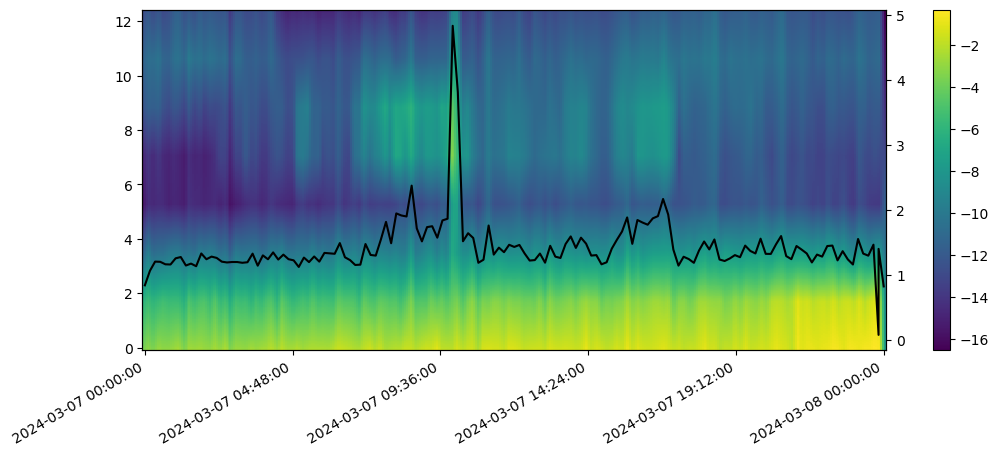

In [7]:
sono = st('sonogram')
_ = multi_feature_plot_mpl(sono, xds_ac['autoencoder_loss'])

Text(0, 0.5, 'Autoencoder loss')

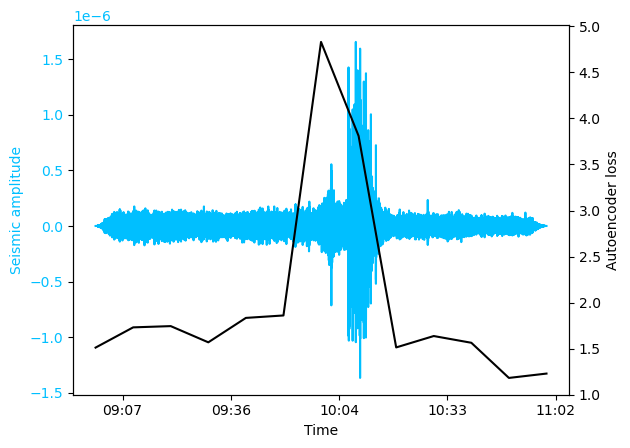

In [8]:
rawdata.trim(UTCDateTime(2024,3,7,9,0), UTCDateTime(2024,3,7,11,0,0))
rawdata.detrend('demean')
rawdata.taper(max_percentage=0.05)
rawdata.filter('bandpass', freqmin=1, freqmax=6)
fig, ax = plt.subplots()
ax.plot(rawdata.times(type='matplotlib'), rawdata.data, color='deepskyblue')
ax1 = ax.twinx()
acloss = xds_ac['autoencoder_loss'].loc[{'datetime': slice('2024-03-07T9:00:00', '2024-03-07T11:00:00')}]
ax1.plot(mdates.date2num(acloss.datetime), acloss.data, color='black')
ax.tick_params(axis='y', labelcolor='deepskyblue')
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel('Time')
ax.set_ylabel('Seismic amplitude', color='deepskyblue')
ax1.set_ylabel('Autoencoder loss', color='black')
